## Introduction. 



### Importing the nasasaly libraries 

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.datasets import make_swiss_roll # this give a 3d data sample that is in the sape of swiss roll. 
from tqdm import tqdm
from matplotlib.animation import FuncAnimation # for creating animation

device = "cuda"

### DATA sampling using Swiss rool function 

In [2]:
def sample_batch(batch_size,device = 'cpu'):
    data, _ = make_swiss_roll(batch_size)  # We generate a data that looks like a swiss rolle with n_samples number of data points. 
    data = data[:,[2,0]]/10
    data = data * np.array([1,-1])
    return(torch.from_numpy(data).to(device))


### Model architecture 

In [3]:
class MLP(nn.Module):

    def __init__(self, N = 40, data_dim = 2, hidden_dim = 64):
        super(MLP, self).__init__()

        self.network_head = nn.Sequential(nn.Linear(data_dim,hidden_dim),
                                          nn.ReLU(),
                                          nn.Linear(hidden_dim,hidden_dim),
                                          nn.ReLU(),)
        self.network_tail = nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim,hidden_dim),
                                           nn.ReLU(),
                                           nn.Linear(hidden_dim,data_dim * 2),) for t in range(N)])

    def forward(self,x,t):

        h = self.network_head(x) # [batch_size, hidden_dim]
        tmp = self.network_tail[t](h) # [batch_size, data_dim *2]
        mu,h = torch.chunk(tmp,2,dim=1)
        var = torch.exp(h)
        std = torch.sqrt(var)
        return mu, std

### Diffusion Model Class 


Forward diffusion Kernel 

$$\mathcal{N}\left(x^{(t)},\underbrace{x^{(t-1)}\sqrt{1-\beta_t}}_{\text{mu}},\underbrace{I \beta_t}_{\text{std}} \right)$$


We are uisng the reparamatriztion tecnic

In [4]:
class DiffusionModule():

    def __init__(self,T, model: nn.Module,device,dim = 2):
        self.betas = (torch.sigmoid(torch.linspace(-18,10,T)) * (3e-1 - 1e-5) + 1e-5).to(device)
        self.alphas = (1 - self.betas).to(device)
        self.alphas_bar = torch.cumprod(self.alphas,0).to(device)
        self.T = T
        self.model = model
        self.dim = dim
        self.device = device

    def forward_porcess(self,x0, t):
        """
        :param data: data
        :param t: Number of diffusion steps
        """

        assert t > 0, 'ArithmeticError: t must be gratter thin zero'

        t = t -1 # Becouse we are starting indexing at 0 

        mu = torch.sqrt(self.alphas_bar[t]) * x0
        std =  torch.sqrt(1-self.alphas_bar[t])
        epsilon =  torch.randn_like(x0)
        xt = mu + epsilon * std 
 
        sigma_q = torch.sqrt(((1-self.alphas_bar[t-1])/(1-self.alphas_bar[t]))*self.betas[t]) 
        m1 = torch.sqrt(self.alphas_bar[t-1]) * self.betas[t] / (1- self.alphas_bar[t])
        m2 =  torch.sqrt(self.alphas[t])* (1- self.alphas_bar[t-1]) / (1- self.alphas_bar[t])
        mu_q = m1*x0 + m2 *xt

        return mu_q, sigma_q, xt

    def reverse_process(self, xt, t):

        assert t > 0, 't should be greatter then zero'
        assert t <= self.T, 't should be less then or equl to self.T'

        t = t - 1 # becouse we are starting indexing at 0 
        mu, std = self.model(xt, t)
        epsilon =  torch.randn_like(xt)
        return mu,std, mu + torch.randn_like(xt) * std 


    def sample(self,batch_size,device):

        noise = (torch.randn((batch_size,self.dim))).to(device)
        x = noise 

        samples = [x]
        for t in range(self.T, 0 , -1):
            _,_,x = self.reverse_process(x,t)
            samples.append(x)

        return samples[::-1]

    def get_loss(self,x0):
        """ 
        :param x0: batch [batch_size, self.dim]
        """

        t = torch.randint(2,40+1,(1,)).to(self.device)
        mu_q, sigma_q, xt = self.forward_porcess(x0,t)
        mu_p, sigma_p, xt_minus1 = self.reverse_process(xt.float(),t)

        KL = torch.log(sigma_p) - torch.log(sigma_q) + (sigma_q**2 + (mu_q - mu_p)**2)/(2* sigma_p **2)
        K =  - KL.mean() # should be mazimise 
        loss = - K # should be minimised 
        return loss

### Defination of plot function

In [5]:
def plot(model,file_name,device):
    fontsize = 14
    fig = plt.figure(figsize = (10,6))
    N = 5_000
    x0 = sample_batch(N).to(device)
    samples = model.sample(N,device = device)


    data = [x0.to('cpu'), model.forward_porcess(x0,20)[-1].to('cpu'),model.forward_porcess(x0,40)[-1].to('cpu')]
    for i in range(3):
        plt.subplot(2,3,1+i)
        plt.scatter(data[i][:,0].data.numpy(),data[i][:,1].data.numpy(),alpha=0.1,s=2)
        plt.xlim([-2,2])
        plt.ylim([-2,2])
        plt.gca().set_aspect('equal')

        if i == 0: plt.ylabel(r'$q(\mathbf{x}^{(0...T)})$',fontsize = fontsize)
        if i == 0: plt.title(r'$t=0$',fontsize = fontsize)
        if i == 1: plt.title(r'$t=\frac{T}{2}$',fontsize = fontsize)
        if i == 2: plt.title(r'$t=T$',fontsize = fontsize)
    time_step = [1,20,40]
    for i in range(3):
        plt.subplot(2,3,4+i)
        plt.scatter(samples[time_step[i]][:,0].data.to('cpu').numpy(),samples[time_step[i]][:,1].data.to('cpu').numpy(),alpha=0.1,c= 'r',s=2)
        plt.xlim([-2,2])
        plt.ylim([-2,2])
        plt.gca().set_aspect('equal')


        if i == 0: plt.ylabel(r'$P(\mathbf{x}^{(0...T)})$',fontsize = fontsize)
    plt.savefig(file_name,bbox_inches='tight')
    plt.close()

### Train function

In [6]:

def train(Diffusion_model, optimizer, batch_size, nb_epoch,device):

    traning_loss = []
    traning_loss_helper = []
    for epoch in tqdm(range(nb_epoch)):
        x0 = sample_batch(batch_size,device)
        loss = Diffusion_model.get_loss(x0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        traning_loss_helper.append(loss.item())

        if epoch% 2000 == 0: 
            traning_loss.append(np.average(traning_loss_helper))
            traning_loss_helper = []
            plt.plot(traning_loss)
            plt.savefig(f'fig/training_loss_epoch_{epoch}.png')
            plt.close()

            plot(Diffusion_model,f'fig/traning_epoch_{epoch}.png',device)

    return traning_loss



### Traning 

In [ ]:
device = 'cuda'
mlp_model = MLP(hidden_dim=128).to(device)
model = DiffusionModule(40,mlp_model,device)
optimizer = torch.optim.Adam(mlp_model.parameters(),lr = 1e-4)
_ = train(model, optimizer, 64_000, 300_000,device)

### Working and testing 

In [7]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
print(available_gpus)

In [9]:
torch.cuda.empty_cache()


In [8]:
torch.save(mlp_model,'model_paper1_2')

NameError: name 'mlp_model' is not defined

In [6]:
mlp_model = torch.load("model_paper1")

In [11]:
torch.cuda.is_available()

False

In [11]:
model = DiffusionModule(40,mlp_model,'cuda')

In [12]:
plot(model,"test.png",'cuda')

In [13]:
sample = model.sample(5_000,'cuda')

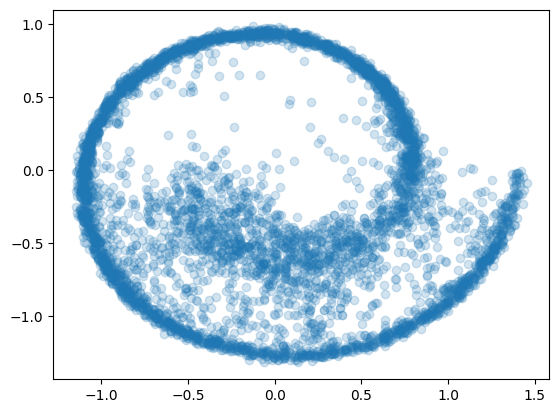

In [14]:
t = 8
plt.scatter(sample[t][:,0].data.to("cpu"),sample[t][:,1].data.to("cpu"),alpha=0.2)

In [15]:

x_data = sample[40][:, 0].data.to("cpu")
y_data = sample[40][:, 1].data.to("cpu")

# Calculate the limits based on the entire dataset
x_min = min(x_data)
x_max = max(x_data)
y_min = min(y_data)
y_max = max(y_data)


def create_scatter_plot(t, sample):
    x_data = sample[t][:, 0].data.to("cpu")
    y_data = sample[t][:, 1].data.to("cpu")
    
    plt.scatter(x_data, y_data, alpha=0.2,s=1)
    plt.title(f'Time Step {t}')
    
    # Set fixed axis limits
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

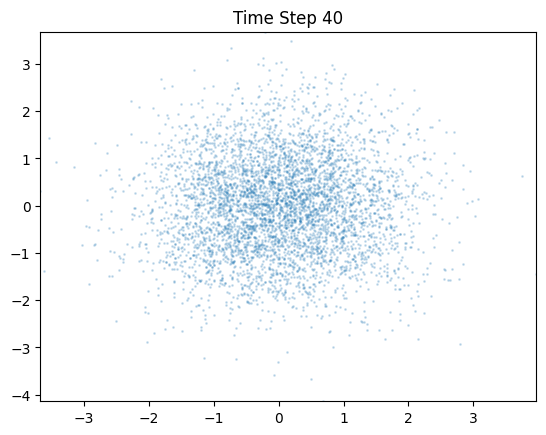

In [16]:
# Function to update the plot
def update(t):
    plt.clf()  # Clear the previous plot
    create_scatter_plot(t, sample)

# Create a figure and axis for the animation
fig, ax = plt.subplots()

# Create the animation
ani = FuncAnimation(fig, update, frames=range(40,-1,-1), repeat=False)

# Save the animation as a GIF
ani.save('output.gif', writer='pillow', fps=5)


In [46]:
list(range(40,-1,-1))

[40,
 39,
 38,
 37,
 36,
 35,
 34,
 33,
 32,
 31,
 30,
 29,
 28,
 27,
 26,
 25,
 24,
 23,
 22,
 21,
 20,
 19,
 18,
 17,
 16,
 15,
 14,
 13,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1,
 0]

In [59]:
optimizer = torch.optim.Adam(mlp_model.parameters(),lr = 1e-4)
_ = train(model, optimizer, 64_000, 300_000,"cuda")

 61%|██████    | 182000/300000 [41:31<26:55, 73.06it/s]  


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.79 GiB total capacity; 7.07 GiB already allocated; 18.88 MiB free; 7.07 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

<Figure size 1000x600 with 0 Axes>